In [1]:
import scipy.optimize as optimize

import pandas_datareader as pdr
import datetime 
import pandas as pd


In [2]:


def bond_ytm(price, par, T, coup, freq=2, guess=0.05):
    freq = float(freq)
    periods = T*freq
    coupon = coup/100.*par/freq
    dt = [(i+1)/freq for i in range(int(periods))]
    def ytm_func(y):
        return(sum([coupon/(1+y/freq)**(freq*t) for t in dt]) +
               par/(1+y/freq)**(freq*T) - price)
        
    return optimize.newton(ytm_func, guess)

In [3]:
def float_dividend_tbill(tbill_rate_in_percent, 
                                 issue_spread_in_bips, par=25.00):
    rate_in_percent = tbill_rate_in_percent + issue_spread_in_bips/100.0;
    dividend = par * rate_in_percent / 100.0
    return dividend

assert(float_dividend_tbill(1.5, 137)== 25 * (1.5 + 137/100)/100)

def float_current_yield(stock_price, tbill_rate_in_percent, issue_spread_in_bips, par=25):
    current_yield =  float_dividend_tbill(tbill_rate_in_percent, issue_spread_in_bips, par)/stock_price
    
    return current_yield


assert(float_current_yield(10.00, 1.6, 340, 25) == 0.125)

def float_market_spread_in_percent(stock_price, tbill_rate_in_percent, 
                                   issue_spread_in_bips, par=25):
    spread = float_current_yield(stock_price, tbill_rate_in_percent, 
                                 issue_spread_in_bips, par) *100 \
               - (tbill_rate_in_percent )
    return spread



float_market_spread_in_percent(15.00, 1.6, 340, 25)

# Predict price of FloatingReset given a new Tbill rate
# with an existing market spread

def declared_dividend(tbill_rate_in_percent, issue_spread_in_bips, par=25):
    declared_yield = (tbill_rate_in_percent + issue_spread_in_bips/100)
    yearly_dividend = declared_yield / 100 * par
    return yearly_dividend

    
def float_price_given_tbill_and_market_spread(tbill_rate_in_percent,
                                              market_spread_in_percent, 
                                              issue_spread_in_bips, par=25):

    yearly_dividend = declared_dividend(tbill_rate_in_percent, issue_spread_in_bips, par)
    demanded_yield_in_percent = tbill_rate_in_percent + market_spread_in_percent
    price = yearly_dividend/demanded_yield_in_percent*100
   #  print(yearly_dividend, demanded_yield_in_percent, price)
    return price


# float_price_given_tbill_and_market_spread(1.4, 6.2, 418,25)

def float_capital_gain_given_tbill_and_market_spread(current_price, 
                                                    tbill_rate_in_percent,
                                                     market_spread_in_percent,
                                                    issue_spread_in_bips,
                                                    par=25):
    new_price = float_price_given_tbill_and_market_spread(tbill_rate_in_percent,
                                                          market_spread_in_percent,
                                                         issue_spread_in_bips,
                                                         par)
    capital_gain_in_dollars = (new_price - current_price)
    return capital_gain_in_dollars

    
cap_gain = float_capital_gain_given_tbill_and_market_spread(18.60, 1.4, 6.1943, 418,25)

def net_gain_cg_and_dividend(num_years, current_price, tbill_rate_in_percent,
                            market_spread_in_percent, issue_spread_in_bips, par=25) :
    cap_gain = float_capital_gain_given_tbill_and_market_spread(current_price,
                                                                tbill_rate_in_percent,
                                                                market_spread_in_percent,
                                                                issue_spread_in_bips,
                                                                par=25)
    dividend_gain= num_years * declared_dividend(tbill_rate_in_percent,
                                                 issue_spread_in_bips,par)
    # print("Cap Gain: ", cap_gain)
    # print("Div Gain:", dividend_gain)
    return cap_gain + dividend_gain


# net_gain = net_gain_cg_and_dividend(1, 18.60, 1.4, 6.1943, 418,25)

# computes total gain of a preferred share over a number of years.
# this includes the predicted capital gain (or loss), plus the dividend income

def annualized_gain_cg_and_dividend_decimal(num_years, current_price, tbill_rate_in_percent,
                            market_spread_in_percent, issue_spread_in_bips, par=25) :
    net_gain =  net_gain_cg_and_dividend(num_years, current_price,
                                                                tbill_rate_in_percent,
                                                                market_spread_in_percent,
                                                                issue_spread_in_bips,
                                                                par=25)
    # print("Net Gain: ", net_gain)
    net_gain_decimal = net_gain/current_price;
    # print("Net Gain Decimal", net_gain_decimal)
    annualized_gain = (1+net_gain_decimal) ** (1/num_years) - 1
    # print("Annualized", annualized_gain)
    return annualized_gain


annualized_gain_cg_and_dividend_decimal(2,18.6,1.4,6.2,418)



0.06622797996636631

In [90]:
foo = pdr.get_data_yahoo('SLF-pj.TO', 
                          start=datetime.datetime(2010, 12, 1), 
                          end=datetime.datetime(2019, 12, 26))

In [89]:
foo.head(10
        )

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-06-03,13.95,13.90,13.95,13.95,1900.0,13.728667
2019-06-04,13.90,13.75,13.90,13.88,2150.0,13.659779
2019-06-05,13.85,13.75,13.85,13.75,5030.0,13.531841
2019-06-06,13.91,13.75,13.91,13.75,7808.0,13.531841
2019-06-07,13.65,13.40,13.58,13.50,2100.0,13.285808
2019-06-10,13.62,13.44,13.44,13.59,102500.0,13.374380
2019-06-11,13.60,13.50,13.50,13.60,1000.0,13.384221
2019-06-12,13.80,13.64,13.64,13.80,6976.0,13.581048
2019-06-13,13.65,13.60,13.65,13.60,300.0,13.384221


In [6]:
floats = pd.read_csv('./floats.csv')

In [7]:
floats.head()

,Ticker,Rating,Spread,Price,Reference,Mult
0,TRI.PR.B,P3H,0.0,13.22,P,0.7
1,PWF.PR.A,P2L,NaN,12.86,P,0.7
2,BAM.PR.E,P2L,NaN,16.19,P,1.0
3,BCE.PR.D,P3I,0.0,15.41,P,1.0
4,BCE.PR.B,P3I,0.0,15.44,P,1.0


In [8]:
tprefs = floats[floats["Reference"]!='P'].copy()

In [9]:
tprefs.dtypes


Ticker        object
Rating        object
Spread       float64
Price        float64
Reference     object
Mult         float64
dtype: object

In [10]:
TBILL_PERCENT = 1.66

In [11]:
# float_market_spread_in_percent(stock_price, tbill_rate_in_percent, 
#                                   issue_spread_in_bips, par=25)
tprefs["MSpread"] = [round(float_market_spread_in_percent(price,TBILL_PERCENT,spread),4) for (price,spread) in 
     zip(tprefs["Price"],tprefs["Spread"])]

In [12]:
tprefs.sort_values(by=['Rating','MSpread'])


,Ticker,Rating,Spread,Price,Reference,Mult,MSpread
13,AIM.PR.B,NR,375.0,16.33,T,NaN,6.6223
41,SLF.PR.J,P1L,141.0,13.41,T,NaN,4.0633
27,SLF.PR.K,P1L,217.0,16.40,T,NaN,4.1784
42,GWO.PR.O,P2H,130.0,13.70,T,NaN,3.7415
37,PWF.PR.Q,P2H,160.0,13.94,T,NaN,4.1865
17,BNS.PR.D,P2Hb,100.0,24.90,T,NaN,1.0107
22,BMO.PR.A,P2Hb,115.0,24.51,T,NaN,1.2062
19,BNS.PR.F,P2Hb,134.0,24.56,T,NaN,1.3937
40,MFC.PR.P,P2I,141.0,13.55,T,NaN,4.0042
21,IFC.PR.D,P2I,266.0,18.00,T,NaN,4.3400


In [13]:
ms_averages = tprefs[["Rating","MSpread"]].groupby(
    ['Rating']).agg(AvgSpread=('MSpread','mean')).reset_index()

,Rating,AvgSpread
0,NR,6.622300
1,P1L,4.120850
2,P2H,3.964000
3,P2Hb,1.203533
4,P2I,4.172100
5,P2L,4.623640
6,P3H,4.598150
7,P3I,5.020600
8,P3L,5.347000
9,P4H,7.425500


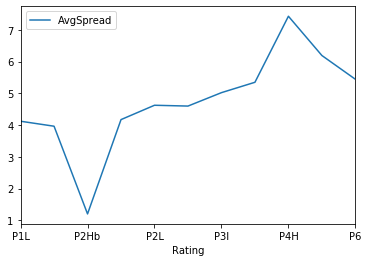

In [14]:
#vxticks = [x for x in ms_averages['Rating'].values if x != 'NR']
ax = ms_averages[ms_averages['Rating']!='NR'].plot(x="Rating",y='AvgSpread')

ms_averages

In [15]:
tpm = tprefs.merge(ms_averages,on='Rating')

In [16]:
tpm.head()

,Ticker,Rating,Spread,Price,Reference,Mult,MSpread,AvgSpread
0,AZP.PR.C,P5H,418.0,18.60,T,NaN,6.1895,6.1895
1,AIM.PR.B,NR,375.0,16.33,T,NaN,6.6223,6.6223
2,BPO.PR.S,P3I,348.0,19.15,T,NaN,5.0502,5.0206
3,FFH.PR.D,P3I,315.0,18.50,T,NaN,4.8400,5.0206
4,FFH.PR.J,P3I,285.0,17.28,T,NaN,4.8649,5.0206


In [17]:
tpm['SpreadToAverage'] = tpm['MSpread'] - tpm['AvgSpread']

In [18]:
# Now that we have Market Spread, figure out total gain after a year, and an assumed
# Tbill rate (say 1.4)
#
# annualized_gain_cg_and_dividend_decimal(num_years, current_price, tbill_rate_in_percent,
#                            market_spread_in_percent, issue_spread_in_bips, par=25)
#
# [round(float_market_spread_in_percent(price,TBILL_PERCENT,spread),3) for (price,spread) in 
#     zip(tprefs["Price"],tprefs["Spread"])]



TBILL_SCN = {"SlightDrop": (1.4, 1), "BigDrop": (1.14,1) , "Panic": (0.7,1)}

def create_tbill_scenarios_from_mspread(mspread_delta,df) :
    df["EffMSpread"] = df["MSpread"] + mspread_delta
    df["MSpread_Delta"] = mspread_delta
    for scn_name,(rate,years) in TBILL_SCN.items() :
        
        df[scn_name] = [annualized_gain_cg_and_dividend_decimal(years, price, rate, 
                                                 mspread,spread) for (price,mspread,spread) in
                zip(df['Price'], df['EffMSpread'], df['Spread'])]
        
       
    return df

        
create_tbill_scenarios_from_mspread(0, tprefs)

# float_capital_gain_given_tbill_and_market_spread(current_price, 
#                                                    tbill_rate_in_percent,
#                                                     market_spread_in_percent,
#                                                   issue_spread_in_bips,

#tprefs["CG"] = [float_capital_gain_given_tbill_and_market_spread(price, 1.4, 
#                                                  mspread,spread)/price for (price,mspread,spread) in
#                 zip(tprefs['Price'], tprefs['MSpread'], tprefs['Spread'])] 
# tprefs.sort_values(by=['Scn1'], ascending=False).head()
tprefs.head()

,Ticker,Rating,Spread,Price,Reference,Mult,MSpread,EffMSpread,MSpread_Delta,SlightDrop,BigDrop,Panic
12,AZP.PR.C,P5H,418.0,18.60,T,NaN,6.1895,6.1895,0,0.063207,0.047089,0.017640
13,AIM.PR.B,NR,375.0,16.33,T,NaN,6.6223,6.6223,0,0.061636,0.039296,-0.001481
14,BPO.PR.S,P3I,348.0,19.15,T,NaN,5.0502,5.0502,0,0.051391,0.034649,0.003566
15,FFH.PR.D,P3I,315.0,18.50,T,NaN,4.8400,4.8400,0,0.046847,0.027421,-0.008857
16,GMP.PR.C,P4H,289.0,12.52,T,NaN,7.4255,7.4255,0,0.056293,0.019952,-0.046088


In [19]:
slf = tprefs[tprefs['Ticker']=='SLF.PR.J'].copy()
slf

,Ticker,Rating,Spread,Price,Reference,Mult,MSpread,EffMSpread,MSpread_Delta,SlightDrop,BigDrop,Panic
41,SLF.PR.J,P1L,141.0,13.41,T,NaN,4.0633,4.0633,0,0.011262,-0.038826,-0.134843


In [32]:
# spread deltas
SPREAD_DELTAS = [ 0.25, 0, -0.5, -.8]

foo = pd.concat([create_tbill_scenarios_from_mspread(delta,tprefs.copy()) 
                      for delta in SPREAD_DELTAS], axis = 0)
foo.reset_index(drop=True, inplace=True)

foo

,Ticker,Rating,Spread,Price,Reference,Mult,MSpread,EffMSpread,MSpread_Delta,SlightDrop,BigDrop,Panic
0,AZP.PR.C,P5H,418.0,18.60,T,NaN,6.1895,6.4395,0.25,0.031694,0.014910,-0.015697
1,AIM.PR.B,NR,375.0,16.33,T,NaN,6.6223,6.8723,0.25,0.031935,0.009203,-0.032198
2,BPO.PR.S,P3I,348.0,19.15,T,NaN,5.0502,5.3002,0.25,0.014538,-0.003174,-0.035975
3,FFH.PR.D,P3I,315.0,18.50,T,NaN,4.8400,5.0900,0.25,0.008890,-0.011482,-0.049406
4,GMP.PR.C,P4H,289.0,12.52,T,NaN,7.4255,7.6755,0.25,0.029555,-0.006691,-0.072422
...,...,...,...,...,...,...,...,...,...,...,...,...
123,FTS.PR.I,P3H,145.0,12.95,T,NaN,4.3439,3.5439,-0.80,0.167892,0.117486,0.019516
124,MFC.PR.P,P2I,141.0,13.55,T,NaN,4.0042,3.2042,-0.80,0.177883,0.130055,0.036058
125,SLF.PR.J,P1L,141.0,13.41,T,NaN,4.0633,3.2633,-0.80,0.175760,0.127165,0.031851
126,GWO.PR.O,P2H,130.0,13.70,T,NaN,3.7415,2.9415,-0.80,0.184133,0.135437,0.038730


In [79]:
scenario_names = TBILL_SCN.keys()
rank_names = ['Rank' + x for x in scenario_names]
def rank_group(df):
    for rank_name,scenario_name in zip(rank_names, scenario_names):
        df[rank_name] = [1 if x in df[scenario_name].nlargest(n=5).values else 0 
                         for x in df[scenario_name]]
    df['RankSum'] = df[rank_names].sum(axis=1)
    return df

In [80]:
bar = foo[foo['MSpread_Delta']==0.0].copy()
bar = rank_group(bar)
bar[(bar['RankSlightDrop'] + bar['RankBigDrop'] + bar['RankPanic']) > 0][['Ticker','RankSlightDrop','RankBigDrop','RankPanic','RankSum']]
# bar

,Ticker,RankSlightDrop,RankBigDrop,RankPanic,RankSum
32,AZP.PR.C,1,1,1,3
33,AIM.PR.B,1,1,0,2
34,BPO.PR.S,1,1,1,3
35,FFH.PR.D,1,1,0,2
36,GMP.PR.C,1,0,0,1
37,BNS.PR.D,0,0,1,1
39,BNS.PR.F,0,1,1,2
42,BMO.PR.A,0,0,1,1


In [81]:
ranked = foo.groupby(['MSpread_Delta']).apply(rank_group)
ranked[(ranked['RankSlightDrop'] + ranked['RankBigDrop'] + ranked['RankPanic']) > 0][
    ['Ticker','MSpread_Delta','RankSlightDrop','RankBigDrop','RankPanic','RankSum']].sort_values(
    by='Ticker')

,Ticker,MSpread_Delta,RankSlightDrop,RankBigDrop,RankPanic,RankSum
1,AIM.PR.B,0.25,1,1,1,3
33,AIM.PR.B,0.00,1,1,0,2
0,AZP.PR.C,0.25,1,1,1,3
32,AZP.PR.C,0.00,1,1,1,3
64,AZP.PR.C,-0.50,1,1,1,3
74,BMO.PR.A,-0.50,1,1,1,3
42,BMO.PR.A,0.00,0,0,1,1
106,BMO.PR.A,-0.80,1,1,1,3
101,BNS.PR.D,-0.80,1,1,1,3
69,BNS.PR.D,-0.50,1,1,1,3


In [84]:
ranked[['Ticker','RankSum']].groupby(['Ticker']).agg(
    TotalRankSum=('RankSum','sum')).reset_index().sort_values(by='TotalRankSum',ascending=False)

,Ticker,TotalRankSum
8,BPO.PR.S,11
2,AZP.PR.C,9
7,BNS.PR.F,8
5,BMO.PR.A,7
6,BNS.PR.D,7
0,AIM.PR.B,5
11,FFH.PR.D,5
17,GMP.PR.C,3
20,IFC.PR.D,2
14,FFH.PR.J,1
